In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
%matplotlib inline
import seaborn as sns
sns.set() 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MaxAbsScaler
from sklearn.metrics import accuracy_score
from sklearn.utils.extmath import softmax
from catboost import CatBoostClassifier

train = pd.read_csv('train.csv')

# Разведочный (исследовательский) анализ <a class="anchor" id="section-two-eda"></a>

## Исследуем обучающий набор (train) <a id="section-two-train-df-analysis"></a>

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
train.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [5]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
train.describe(include=['O'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


* Видно, что повторяются каюты. Самый большой порядок дубликата - 8. Значит в одной каюте живут до 8 человек.
* Самым популярным пунктом назначения является TRAPPIST-1e. (5915 чел)
* Больше всего человек летит с планеты Земля. (4602 чел)

## Проведем отчистку данных <a id="section-two-test-df-analysis"></a>
Дропнем колонку с **именем** и **id** пассажиров, это не будет влиять на их выживаемость

In [7]:
train = train.drop(['Name', 'PassengerId'], axis=1)

## Заполним пропуски <a id="section-two-test-df-analysis"></a>

In [8]:
train.isnull().sum()

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

Видим, что есть пропуски данных по 11 переменным

### Начнем с HomePLanet. Заполним пропуски самым частоным значением.

In [9]:
train.HomePlanet.value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

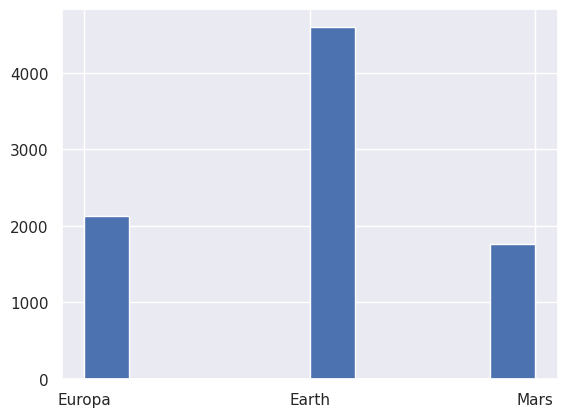

In [10]:
col = 'HomePlanet'
train[col].hist()
train[col].fillna('Earth', inplace=True)

Конвертируем категориальное значение в численное представление.

In [11]:
col = 'HomePlanet'
train[col] = train[col].map({"Earth": 1, "Europa": 2, "Mars": 3})
    
train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,2,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,1,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,2,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,2,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,1,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


### Далее рассмотрим CryoSleep. Заполним пропуски самым частотным значением.

In [12]:
train.CryoSleep.value_counts()

CryoSleep
False    5439
True     3037
Name: count, dtype: int64

In [13]:
col = 'CryoSleep'
train[col].fillna(False, inplace=True)

### Далее рассмотрим Cabin.
Разделим данный столбец на три столбца - **deck/num/side**, которые в дальнейшем могут быть информативны.

При этом значение может иметь то, со сколькими людьми в одной кабине путешествует пассажир.
Поэтому созданим новый признак - **NumCabinMates**, который будет показывать со сколькими людьми в одной кабине путешествует пассажир. 
Можно предположить, что он характеризует количество родственников пассажира на корабле.


In [14]:
train.Cabin.value_counts()

Cabin
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: count, Length: 6560, dtype: int64

In [15]:
relatives_mas = train.Cabin.unique()
relatives_mapping = {}
for el in relatives_mas:
    relatives_mapping[el] = len(train[train['Cabin']==el])

train['NumCabinMates'] = train['Cabin'].copy() 
train['NumCabinMates'] = train['NumCabinMates'].map(relatives_mapping)

train[['Deck', 'NumCabin', 'Side']] = train['Cabin'].str.split('/', expand=True)
train = train.drop('Cabin', axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     8693 non-null   int64  
 1   CryoSleep      8693 non-null   bool   
 2   Destination    8511 non-null   object 
 3   Age            8514 non-null   float64
 4   VIP            8490 non-null   object 
 5   RoomService    8512 non-null   float64
 6   FoodCourt      8510 non-null   float64
 7   ShoppingMall   8485 non-null   float64
 8   Spa            8510 non-null   float64
 9   VRDeck         8505 non-null   float64
 10  Transported    8693 non-null   bool   
 11  NumCabinMates  8693 non-null   int64  
 12  Deck           8494 non-null   object 
 13  NumCabin       8494 non-null   object 
 14  Side           8494 non-null   object 
dtypes: bool(2), float64(6), int64(2), object(5)
memory usage: 900.0+ KB


In [16]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,NumCabinMates,Deck,NumCabin,Side
0,2,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,B,0,P
1,1,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,F,0,S
2,2,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2,A,0,S
3,2,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2,A,0,S
4,1,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,F,1,S


#### Восстановим пропуски и переведем из категориального вида в численное представление только что созданные столбцы

In [17]:
train.Deck.value_counts()

Deck
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: count, dtype: int64

<Axes: >

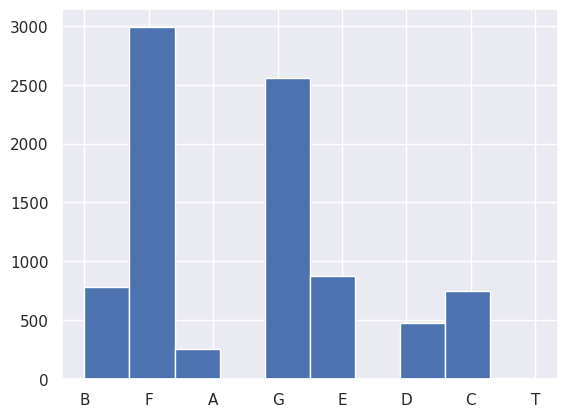

In [18]:
train['Deck'].fillna('F', inplace=True)
train['Deck'].hist()


In [19]:
col = 'Deck'
train[col] = train[col].map({"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8})
    
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,NumCabinMates,Deck,NumCabin,Side
0,2,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,2,0,P
1,1,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,6,0,S
2,2,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2,1,0,S
3,2,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2,1,0,S
4,1,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,6,1,S


<Axes: >

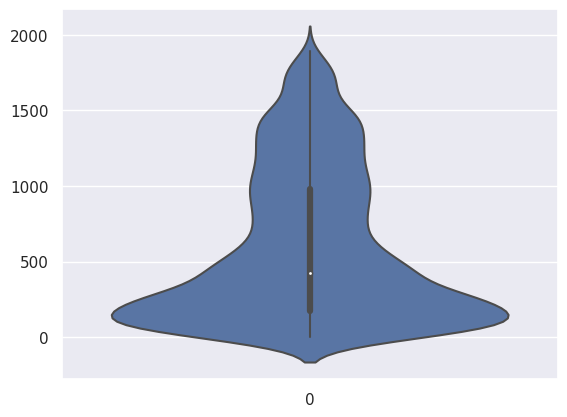

In [20]:
train['NumCabin'] = train['NumCabin'].fillna(train['NumCabin'].median())
sns.violinplot(train['NumCabin'])

In [21]:
train.Side.value_counts()

Side
S    4288
P    4206
Name: count, dtype: int64

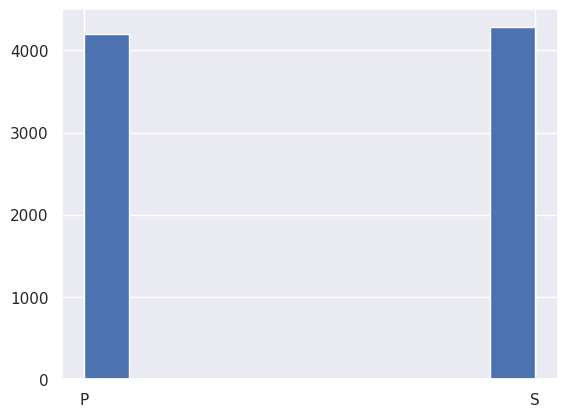

In [22]:
train['Side'].hist()
train['Side'].fillna('S', inplace=True)

In [23]:
col = 'Side'
train[col] = train[col].map({"S": 1, "P": 2})
    
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,NumCabinMates,Deck,NumCabin,Side
0,2,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,2,0,2
1,1,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,6,0,1
2,2,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2,1,0,1
3,2,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2,1,0,1
4,1,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,6,1,1


### Далее рассмотрим Destination. Заполним пропуски самым частоным значением.

In [24]:
train.Destination.value_counts()

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

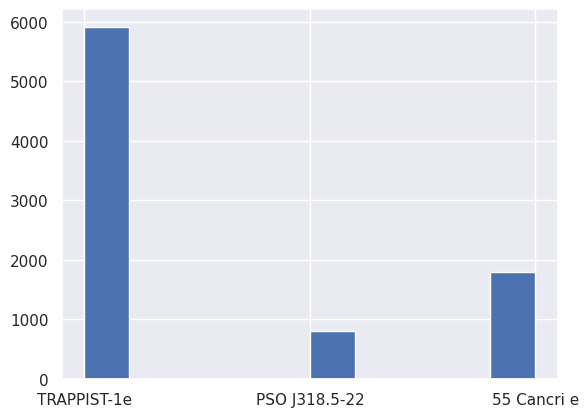

In [25]:
col = 'Destination'
train[col].hist()
train[col].fillna('TRAPPIST-1e', inplace=True)

Конвертируем категориальное значение в численное представление.

In [26]:
col = 'Destination'
dest_mapping = {"TRAPPIST-1e": 1, "55 Cancri e": 2, "PSO J318.5-22": 3}
train[col] = train[col].map(dest_mapping)
    
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,NumCabinMates,Deck,NumCabin,Side
0,2,False,1,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,2,0,2
1,1,False,1,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,6,0,1
2,2,False,1,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2,1,0,1
3,2,False,1,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2,1,0,1
4,1,False,1,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,6,1,1


### Далее рассмотрим Age. Заполним пропуски медианой.

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


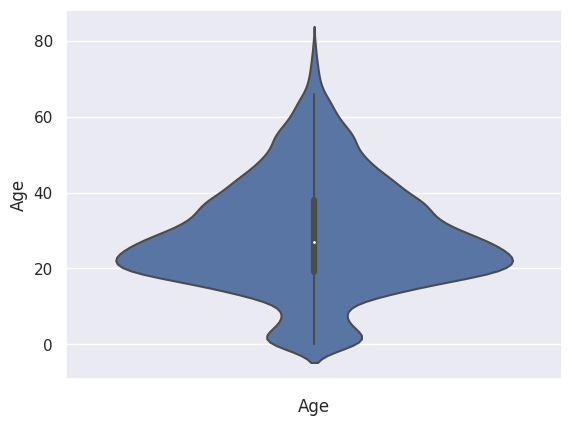

In [27]:
col = 'Age'
data = train[col]
sns.violinplot(y=data)
plt.xlabel(col)
plt.show()

train[col].fillna(train[col].median(), inplace=True)

### Далее рассмотрим VIP. Заполним пропуски самым частотным значением.

In [28]:
train.VIP.value_counts()

VIP
False    8291
True      199
Name: count, dtype: int64

In [29]:
col = 'VIP'
train[col].fillna(False, inplace=True)

### Далее рассмотрим RoomService. Заполним пропуски на медиану.

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


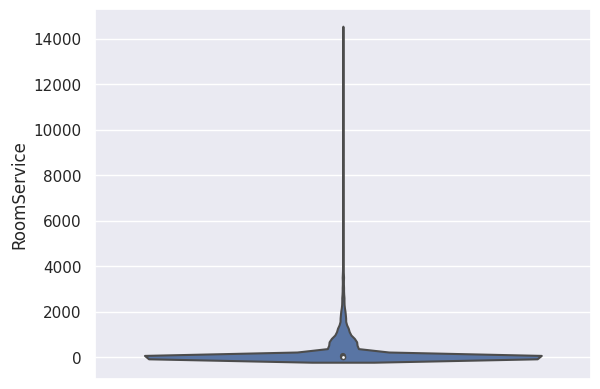

In [30]:
col = 'RoomService'

data = train[col]
sns.violinplot(y=data)
plt.show()

train[col].fillna(train[col].median(), inplace=True)

### Далее рассмотрим FoodCourt. Заполним пропуски на медиану.

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


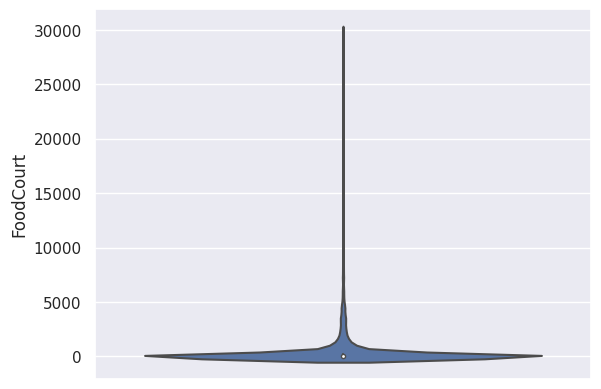

In [31]:
col = 'FoodCourt'

data = train[col]
sns.violinplot(y=data)
plt.show()

train[col].fillna(train[col].median(), inplace=True)

### Далее рассмотрим ShoppingMall. Заполним пропуски на медиану.

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


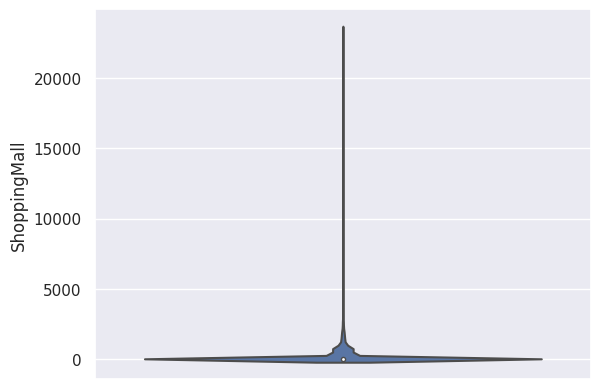

In [32]:
col = 'ShoppingMall'

data = train[col]
sns.violinplot(y=data)
plt.show()

train[col].fillna(train[col].median(), inplace=True)

### Далее рассмотрим Spa. Заполним пропуски на медиану.

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


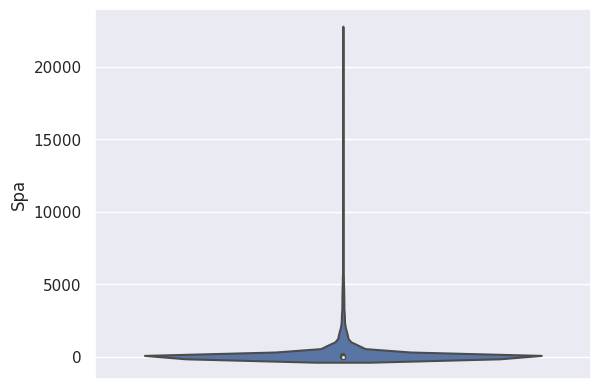

In [33]:
col = 'Spa'

data = train[col]
sns.violinplot(y=data)
plt.show()

train[col].fillna(train[col].median(), inplace=True)

### Далее рассмотрим VRDeck. Заполним пропуски на медиану.

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


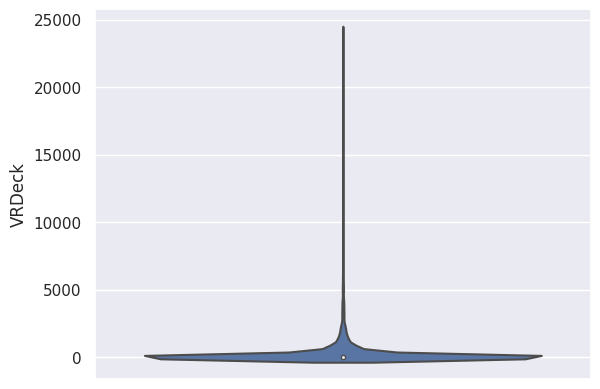

In [34]:
col = 'VRDeck'

data = train[col]
sns.violinplot(y=data)
plt.show()

train[col].fillna(train[col].median(), inplace=True)

### Проверим, что все пропуски заполнены

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     8693 non-null   int64  
 1   CryoSleep      8693 non-null   bool   
 2   Destination    8693 non-null   int64  
 3   Age            8693 non-null   float64
 4   VIP            8693 non-null   bool   
 5   RoomService    8693 non-null   float64
 6   FoodCourt      8693 non-null   float64
 7   ShoppingMall   8693 non-null   float64
 8   Spa            8693 non-null   float64
 9   VRDeck         8693 non-null   float64
 10  Transported    8693 non-null   bool   
 11  NumCabinMates  8693 non-null   int64  
 12  Deck           8693 non-null   int64  
 13  NumCabin       8693 non-null   object 
 14  Side           8693 non-null   int64  
dtypes: bool(3), float64(6), int64(5), object(1)
memory usage: 840.6+ KB


In [36]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,NumCabinMates,Deck,NumCabin,Side
0,2,False,1,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,2,0,2
1,1,False,1,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,6,0,1
2,2,False,1,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2,1,0,1
3,2,False,1,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2,1,0,1
4,1,False,1,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,6,1,1


## Посмотрим на корреляцию величин

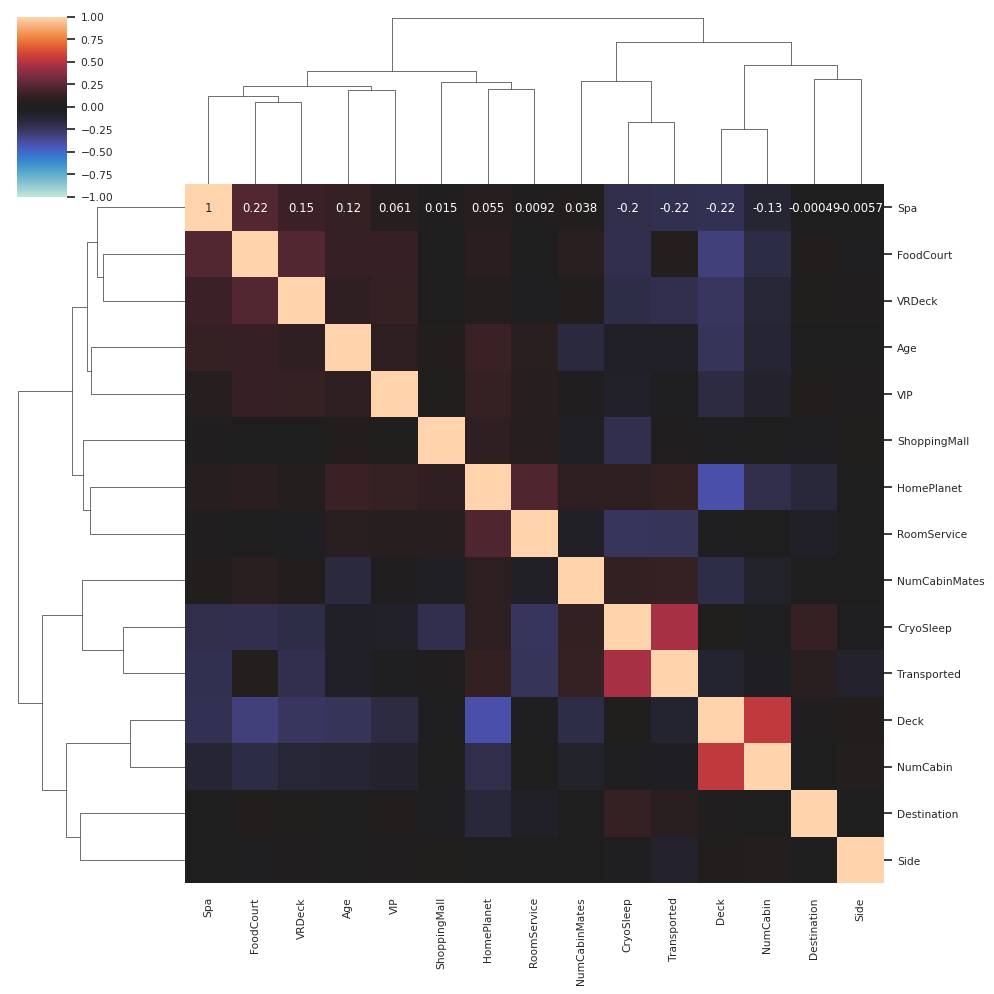

In [37]:
'''
plt.figure(figsize=(15,6))
sns.heatmap(train.corr(), 
            vmin=-1.0,
            vmax=1.0, 
            cmap="icefire",
            square=True,
            annot=True)
'''
sns.set (font_scale=0.7)
sns.clustermap(
        train.corr("pearson"),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=True
    )

Видим, что CryoSleep имеет самую сульную корреляцию к Transported. И видим, что наблюдается обратная корреляция к тратам на различные развлечения и вероятностью транспортировки. Это логично, так как пассажир, который был в состоянии анабиоза в течение транспортировки, не мог тратить денег на дополнительные развлечения.

Из-за неустраняемых выбросов сложно судить о важности RoomService, FoodCourt ShoppingMall, Spa, VRDeck, VIP. Тем не менее, можно сделать вывод, что Spa, VRDeck и RoomService полезны, а FoodCourt, ShoppingMall и VIP менее существенны

# Зависимости между Признаками (Features) и Ответом (Transported)
В этом разделе, мы анализируем зависимости между разными признаками по отношению к Транспортировке(Transported). Мы увидим как разные значения признаков отображают разные шансы на транспортировку. Мы также построим разные виды диаграмм, для того, чтобы представить наши данные и находки.

In [38]:
transported = train[train['Transported'] == True]
not_transported = train[train['Transported'] == False]

print ("transported: %i (%.1f%%)"%(len(transported), (len(transported))/len(train)*100.0))
print ("Not transported: %i (%.1f%%)"%(len(not_transported), (len(not_transported))/len(train)*100.0))
print ("Total: %i"%len(train))

transported: 4378 (50.4%)
Not transported: 4315 (49.6%)
Total: 8693


## CryoSleep vs Transported - Одна из самых показательных фичей
Пассажиры, переведенные в состояние анабиоза на время рейса, имеют гораздо большие шансы на транспортировку.

In [39]:
train.groupby('CryoSleep').Transported.value_counts()

CryoSleep  Transported
False      False          3761
           True           1895
True       True           2483
           False           554
Name: count, dtype: int64

In [40]:
train[['CryoSleep', 'Transported']].groupby('CryoSleep', as_index = False).mean()

,CryoSleep,Transported
0,False,0.335042
1,True,0.817583


/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='CryoSleep', ylabel='Transported'>

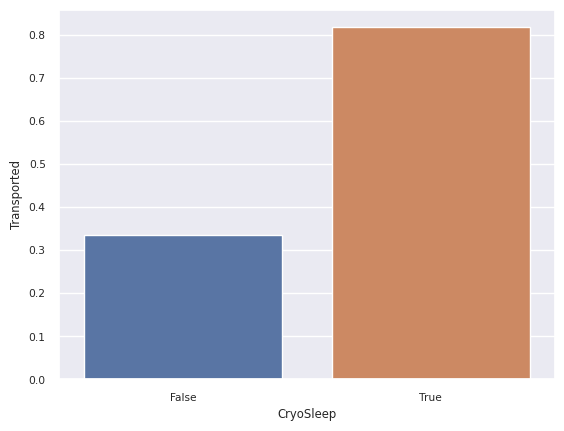

In [41]:
sns.barplot(x='CryoSleep', y='Transported', data=train, errorbar=None)

## NumCabinMates vs Transported
У пассажиров, 3-6 соседей в каюте имеют чуть большие шансы на транспортировку, чем у остальных.

In [42]:
train.NumCabinMates.value_counts()

NumCabinMates
1    5427
2    1372
3     747
4     416
5     235
0     199
6     198
7      91
8       8
Name: count, dtype: int64

In [43]:
train.groupby('NumCabinMates').Transported.value_counts()

NumCabinMates  Transported
0              True            100
               False            99
1              False          3009
               True           2418
2              True            817
               False           555
3              True            457
               False           290
4              True            264
               False           152
5              True            142
               False            93
6              True            125
               False            73
7              True             52
               False            39
8              False             5
               True              3
Name: count, dtype: int64

In [44]:
train[['NumCabinMates', 'Transported']].groupby('NumCabinMates', as_index = False).mean()

,NumCabinMates,Transported
0,0,0.502513
1,1,0.445550
2,2,0.595481
3,3,0.611780
4,4,0.634615
5,5,0.604255
6,6,0.631313
7,7,0.571429
8,8,0.375000


/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='NumCabinMates', ylabel='Transported'>

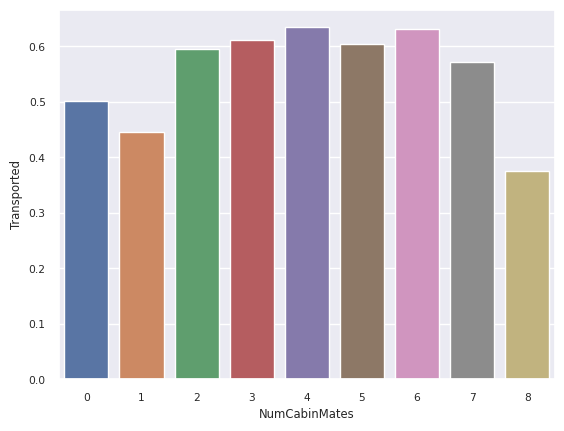

In [45]:
sns.barplot(x='NumCabinMates', y='Transported', data=train, errorbar=None)

## HomePlanet vs Transported
Пассажиры с планеты Europa имеют бОльшие шансы на транспортировку, чем остальные.

In [46]:
train.HomePlanet.value_counts()

HomePlanet
1    4803
2    2131
3    1759
Name: count, dtype: int64

In [47]:
train.groupby('HomePlanet').Transported.value_counts()

HomePlanet  Transported
1           False          2749
            True           2054
2           True           1404
            False           727
3           True            920
            False           839
Name: count, dtype: int64

In [48]:
train[['HomePlanet', 'Transported']].groupby('HomePlanet', as_index = False).mean()

,HomePlanet,Transported
0,1,0.427649
1,2,0.658846
2,3,0.523024


/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='HomePlanet', ylabel='Transported'>

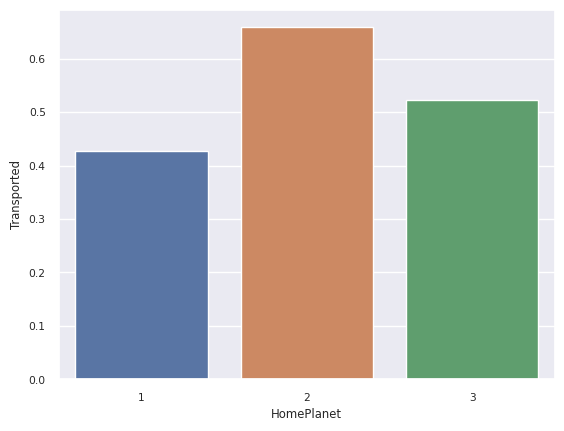

In [49]:
sns.barplot(x='HomePlanet', y='Transported', data=train, errorbar=None)

## Destination vs Transported
Влияния у этой фичи мало, но пассажиры, летящие в *55 Cancri e* имеют чуть большую вероятность транспортировки.

In [50]:
train.Destination.value_counts()

Destination
1    6097
2    1800
3     796
Name: count, dtype: int64

In [51]:
train.groupby('Destination').Transported.value_counts()

Destination  Transported
1            False          3218
             True           2879
2            True           1098
             False           702
3            True            401
             False           395
Name: count, dtype: int64

In [52]:
train[['Destination', 'Transported']].groupby('Destination', as_index = False).mean()

,Destination,Transported
0,1,0.472199
1,2,0.610000
2,3,0.503769


/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Destination', ylabel='Transported'>

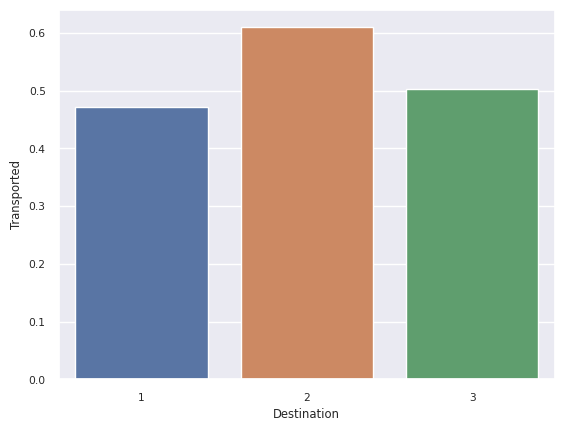

In [53]:
sns.barplot(x='Destination', y='Transported', data=train, errorbar=None)

## Age vs Transported

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

<Axes: xlabel='Destination', ylabel='Age'>

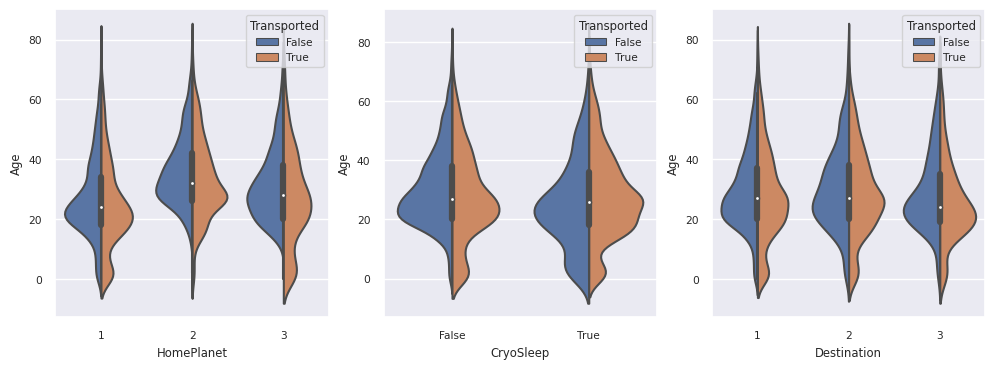

In [54]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)


sns.violinplot(x="HomePlanet", y="Age", hue="Transported", data=train, split=True, ax=ax1)
sns.violinplot(x="CryoSleep", y="Age", hue="Transported", data=train, split=True, ax=ax2)
sns.violinplot(x="Destination", y="Age", hue="Transported", data=train, split=True, ax=ax3)

* С Земли были транспортировано чуть больше детей, чем не транспортировано
* С Европы почти не было детей на борту, а те, что были - транспортированы
* С Марса были транспортированы все дети до 10 лет

* Дети, которые не были в анабиозе, преимущественно были транспортированы, а взрослые, наоборот, были транспортированы в чуть меньшем кол-ве
* Дети, которые были в анабиозе, в меньшем кол-ве были танспортированы, а взрослые в большем

* Пункт назначения по возрасту дает мало информации, графики схожи

## Deck vs Transported

In [55]:
train.Deck.value_counts()

Deck
6    2993
7    2559
5     876
2     779
3     747
4     478
1     256
8       5
Name: count, dtype: int64

In [56]:
train.groupby('Deck').Transported.value_counts()

Deck  Transported
1     False           129
      True            127
2     True            572
      False           207
3     True            508
      False           239
4     False           271
      True            207
5     False           563
      True            313
6     False          1664
      True           1329
7     True           1321
      False          1238
8     False             4
      True              1
Name: count, dtype: int64

In [57]:
train[['Deck', 'Transported']].groupby('Deck', as_index = False).mean()

,Deck,Transported
0,1,0.496094
1,2,0.734275
2,3,0.680054
3,4,0.433054
4,5,0.357306
5,6,0.444036
6,7,0.516217
7,8,0.200000


/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Deck', ylabel='Transported'>

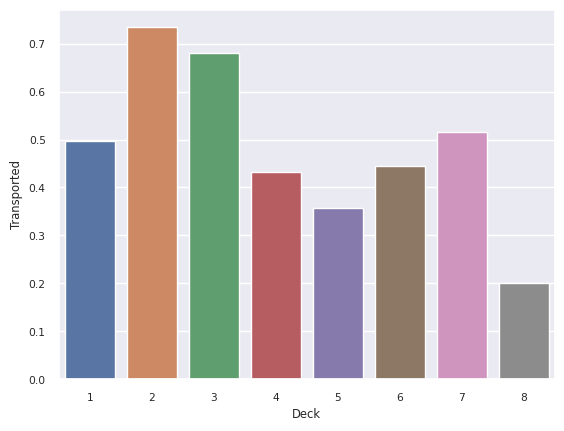

In [58]:
sns.barplot(x='Deck', y='Transported', data=train, errorbar=None)

## Side vs Transported
пассажиры, зашедшие с борта имеют чуть большие шансы на транспортировку, чем зашедшие с порта

In [59]:
train.Side.value_counts()

Side
1    4487
2    4206
Name: count, dtype: int64

In [60]:
train[['Side', 'Transported']].groupby('Side', as_index = False).mean()

,Side,Transported
0,1,0.552708
1,2,0.451260


/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Side', ylabel='Transported'>

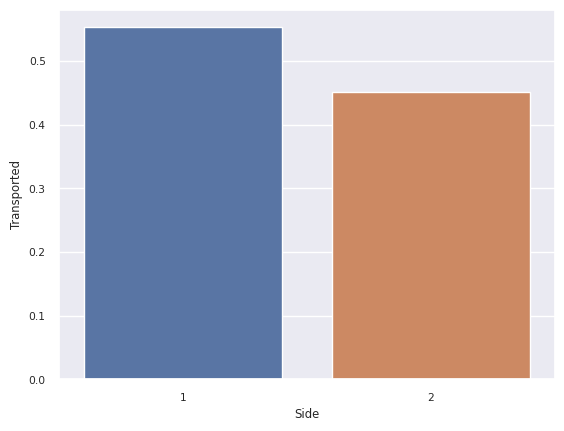

In [61]:
sns.barplot(x='Side', y='Transported', data=train, errorbar=None)

# Feature importance by Logistic Regression

In [62]:
def feature_importances(df):
        
    X = df.drop('Transported', axis=1)
    y = df[['Transported']]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
    
    # Logistic Regression    
    clf_lr = LogisticRegression(random_state = 0)
    clf_lr.fit(X_train, y_train)
    coef_lr = clf_lr.coef_[0]
    
    acc_train_lr = accuracy_score(y_true=y_train, y_pred=clf_lr.predict(X_train))
    acc_test_lr = accuracy_score(y_true=y_test, y_pred=clf_lr.predict(X_test))
    label_lr = f'Importance (LR abs), acc_train = {acc_train_lr:.2%}, acc_test = {acc_test_lr:.2%}'
    
    
    # Random Forest
    clf_rf = RandomForestClassifier(random_state = 0)
    clf_rf.fit(X_train, y_train)
    coef_rf = clf_rf.feature_importances_
    
    acc_train_rf = accuracy_score(y_true=y_train, y_pred=clf_rf.predict(X_train))
    acc_test_rf = accuracy_score(y_true=y_test, y_pred=clf_rf.predict(X_test))
    label_rf = f'Importance (LR abs), acc_train = {acc_train_rf:.2%}, acc_test = {acc_test_rf:.2%}'
    
    # CatBoost
    clf_cat = CatBoostClassifier(random_state = 0)
    clf_cat.fit(X_train, y_train, silent = True)
    coef_cat = clf_cat.feature_importances_
    
    acc_train_cat = accuracy_score(y_true=y_train, y_pred=clf_cat.predict(X_train).astype(bool))
    acc_test_cat = accuracy_score(y_true=y_test, y_pred=clf_cat.predict(X_test).astype(bool))
    label_cat = f'Importance (LR abs), acc_train = {acc_train_cat:.2%}, acc_test = {acc_test_cat:.2%}'

    print(acc_train_lr, acc_train_rf, acc_train_cat)
    print(acc_test_lr, acc_test_rf, acc_test_cat)
    
    feauture_importances = pd.DataFrame({
        'Feature': X.columns,
        'LR': np.abs(coef_lr),
        'RF': coef_rf,
        'CatBoost': coef_cat
    })
    
    feauture_importances = feauture_importances.sort_values(by = 'CatBoost', ascending=False)
    
    sc = MaxAbsScaler()
    feauture_importances[['LR', 'RF', 'CatBoost']] = sc.fit_transform(feauture_importances[['LR', 'RF', 'CatBoost']])
    
    # Plot everything
    
    feauture_importances.plot(kind='bar', x='Feature')
    
#     ax = plt.bar(x=feauture_importances['Feature'], height=feauture_importances['Importance (LR abs)'], label = label_lr)
#     plt.bar(x=feauture_importances['Feature'], height=feauture_importances['Importance (RF)'], label = label_rf, axes=ax)
#     plt.bar(x=feauture_importances['Feature'], height=feauture_importances['Importance (Cat)'], label = label_cat, axes=ax)
#     plt.show()
    

/home/neechan/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/neechan/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/neechan/miniconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

0.7850897376898297 0.9993864089584292 0.503298051848443
0.7865685372585096 0.7989880404783809 0.5045998160073597


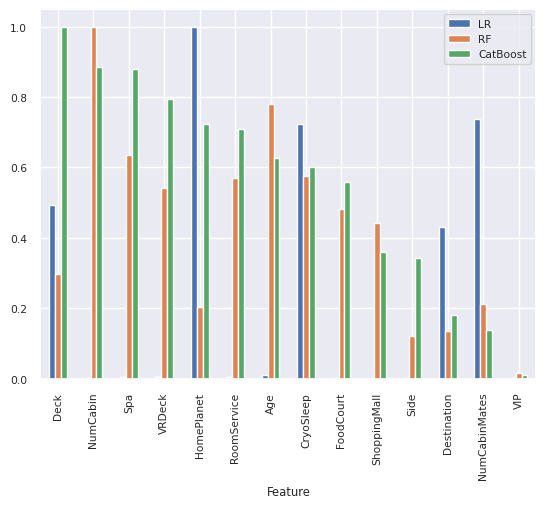

In [63]:
feature_importances(train)

<Axes: >

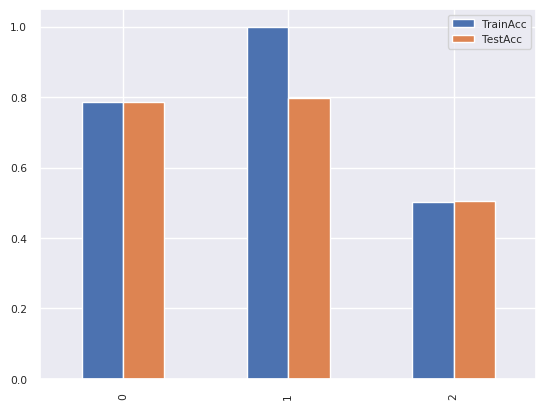

In [64]:
d = {
    'TrainAcc': [0.7850897376898297, 0.9993864089584292, 0.503298051848443],
    'TestAcc': [0.7865685372585096, 0.7989880404783809, 0.5045998160073597]
}
df_acc = pd.DataFrame(data=d)
df_acc.plot.bar()